## Wykrywanie zapalenia płuc

Próba wykorzystania zdjęć rentgenowskich klatki piersiowej do wykrywania zapalenia płuc u pacjentów (tj. przypisanie każdemu obrazowi statusu "zapalenie płuc" (pneumonia) lub "normalny" (normal))

1. Utwórz konto na Kaggle.com
2. Kliknij na swoje zdjęcie profilowe
3. Kliknij na "Konto".
4. Przewiń w dół do sekcji "API
5. Najpierw kliknij "Expire API Token". Upewnij się, że pojawi się powiadomienie o tym, że tokeny API wygasły lub nie istnieją żadne tokeny API.
6. Następnie kliknij "Create New API Token" i pobierz plik `kaggle.json`
7. Prześlij plik `kaggle.json` do google colab.


In [2]:
!pip install kaggle
!mkdir /root/.kaggle
!cp kaggle.json /root/.kaggle/kaggle.json
!chmod 600 kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip
!rm -rf chest_xray/__MACOSX
!rm -rf chest_xray/chest_xray

mkdir: cannot create directory ‘/root/.kaggle’: Permission denied
cp: failed to access '/root/.kaggle/kaggle.json': Permission denied
100%|█████████████████████████████████████▉| 2.29G/2.29G [09:22<00:00, 3.50MB/s]
100%|██████████████████████████████████████| 2.29G/2.29G [09:22<00:00, 4.38MB/s]
Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray/__MACOSX/._chest_xray  
  inflating: chest_xray/__MACOSX/chest_xray/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/._test  
  inflating: chest_xray/__MACOSX/chest_xray/._train  
  inflating: chest_xray/__MACOSX/chest_xray/test/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/test/._NORMAL  
  inflating: chest_xray/__MACOSX/chest_xray/test/._PNEUMONIA  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0001-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0003-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0005-0001.jpeg  
  inflating: chest_xray/__MACOSX/che

### Przygotowanie danych

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from imutils import paths
from sklearn.model_selection import train_test_split

def generate_dataframe(directory):
    img_paths = list(paths.list_images(directory))
    labels = ['normal' if path.find('NORMAL') > -1 else 'pn' for path in img_paths]
    return pd.DataFrame({ 'paths': img_paths, 'labels': labels })

# df contains paths to all images with corresponding labels
all_df = generate_dataframe('/home/przemek/Deep Learning/road-to-deep-learning/road-to-deep-learning/data/pneumonia-xrays/chest_xray')

train_dataset, test_dateset = train_test_split(all_df, test_size=0.2, random_state=42)

print(train_dataset['labels'].value_counts())
print(test_dateset['labels'].value_counts())

pn        3440
normal    1244
Name: labels, dtype: int64
pn        833
normal    339
Name: labels, dtype: int64


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_generators(train_dataset, test_dateset, size=224, batch=64):
    train_generator = ImageDataGenerator(
        rescale=1./255, # multiply each pixel by value
        # augmentation params
        rotation_range=5, # randomly rotate each image by 0 to 5 degrees
        width_shift_range=0.1, # shift image horizontally by 0-10%
        height_shift_range=0.1, # shift image vertically by 0-10%
        validation_split=0.2  # creates two 'subsets': training and validation
    )
    # test on the data without any transformations (original data distribution!)
    test_generator = ImageDataGenerator(rescale=1./255)

    baseargs = {
        "x_col": 'paths',
        "y_col": 'labels',
        "class_labels": ['normal', 'pn'],
        "class_mode": 'binary',  # binary classification
        "target_size": (size, size),  # we can resize the images
        "batch_size": batch, # the number of images we present to the neural network at once
        "seed": 42
    }
    train_generator_flow = train_generator.flow_from_dataframe(
        **baseargs,
        dataframe=train_dataset,  # source data frame
        subset='training')
    validation_generator_flow = train_generator.flow_from_dataframe(
        **baseargs,
        dataframe=train_dataset,
        subset='validation')
    test_generator_flow = test_generator.flow_from_dataframe(
        dataframe=test_dateset,
        shuffle=False,
        **baseargs)

    return train_generator_flow, validation_generator_flow, test_generator_flow

In [3]:
train_generator, validation_generator, test_generator = create_generators(train_dataset, test_dateset, 224, 32)

Found 3748 validated image filenames belonging to 2 classes.
Found 936 validated image filenames belonging to 2 classes.
Found 1172 validated image filenames belonging to 2 classes.


### Model VGG16
![vgg16_architecture](https://neurohive.io/wp-content/uploads/2018/11/vgg16-neural-network.jpg)

VGG16 zawiera 13 warstw Conv2D i 3 warstwy Dense, co daje w sumie ponad 14 milionów parametrów do wytrenowania. Model ten został zaprezentowany na konkursie ImageNet w 2014 roku. Wygrał on, stąd możemy założyć, że znaleziony wtedy zestaw wag sieci potrafi dobrze klasyfikować obrazy.

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16


In [7]:
SIZE = 224
def make_VGGnet():
    m = VGG16(weights = 'imagenet',
              include_top = False,
              input_shape = (SIZE, SIZE, 3))
    for layer in m.layers:
        layer.trainable = False
    # perceptron part
    # vgg part basically creates compressed representation of image
    x = Flatten()(m.output)
    x = Dense(4096, activation="relu")(x)
    x = Dense(1072, activation="relu")(x)
    x = Dropout(0.2)(x)
    predictions = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=m.input, outputs=predictions)
    ## Compile and run

    adam = Adam(learning_rate=0.001)
    model.compile(optimizer=adam,
                  loss='binary_crossentropy',
                  metrics=['accuracy', Recall(name='recall'),
                           Precision(name='precision'), AUC(name='auc')])
    return model

### Callbacks

* **Tensorboard** - narzędzie wizualizacyjne do monitorowania uczenia modelu.
* **EarlyStopping** - zatrzymuje uczenie modelu przed założoną liczbą epok. Zapobiega "overfitting'owi". Jeżeli validation loss nie poprawi się przez N epok o wartość delta, wtedy uczenie modelu zakończy się wcześniej.
* **ModelCheckpoint** - zapisuje model do pliku co epokę. *save_best_only* oznacza, że zapisanie zostanie jedynie model lepszy od poprzedniego.
* **ReduceLROnPlateau** - learning rate zostanie obniżony gdy validation loss nie zmieni się przez N epok

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard, EarlyStopping
from datetime import datetime

def get_callbacks():
    logdir = (
        f'logs/scalars/vgg_{datetime.now().strftime("%m%d%Y-%H%M%S")}'
    )
    tb = TensorBoard(log_dir=logdir) # visualization tool
    es = EarlyStopping(
        monitor="val_loss",
        min_delta=1,  # model should improve by at least 1%
        patience=20,  # amount of epochs  with improvements worse than 1% until the model stops
        verbose=2,
        mode="min",
        restore_best_weights=True,  # restore the best model with the lowest validation error
    )
    mc = ModelCheckpoint(f'model_vgg.hdf5',
                         save_best_only=True,
                         monitor='val_loss',
                         mode='min')

    ## Reduce learning rate if it gets stuck in a plateau
    rlr = ReduceLROnPlateau(monitor='val_loss',
                            factor=0.3,
                            patience=3,
                            min_lr=0.000001,
                            verbose=1)
    return [tb, es, mc, rlr]

### Trenowanie modelu

Model posiada ~14 mln parametrów pobranych z 'imagenet VGG' oraz ~107 mln części klasyfikacyjnej.

In [9]:
from tensorflow.keras.utils import plot_model

def fit_model(train_generator, validation_generator, batch_size=32, epochs=15):
    model = make_VGGnet()
    model.summary()
    plot_model(model, to_file='vgg16.jpg', show_shapes=True)

    model_history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_steps=validation_generator.n/batch_size,
                              epochs=epochs,
                              verbose=1,
                              callbacks=get_callbacks())  # set up callbacks
    return model, model_history

In [10]:
vgg_model, vgg_model_hist = fit_model(train_generator, validation_generator, epochs=15)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
def plot_history(history):

    fig = plt.figure(figsize = (18 , 6))

    fig.add_subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train loss', 'valid loss'])
    plt.grid(True)
    plt.plot()

    fig.add_subplot(1,2,2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train acc', 'valid acc'])
    plt.grid(True)
    plt.plot()

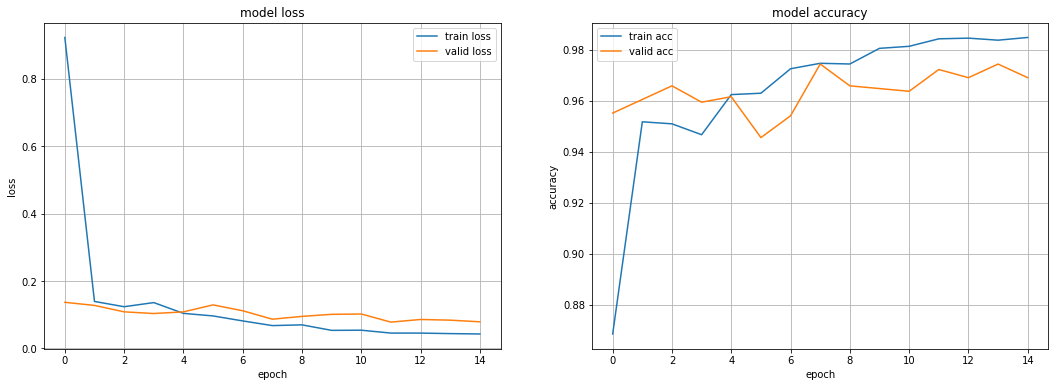

In [12]:
plot_history(vgg_model_hist)

### Tensorboard

Narzędzie pozwalające na monitorowanie procesu trenowania lub jego wyników.

In [1]:
%load_ext tensorboard
%tensorboard --logdir logs

Launching TensorBoard...

### Wizualizacja atencji modelu z GradCAM

Grad-CAM jest algorytmem, który pozwala nam generować mapy termiczne, które pokazują które części obrazu miały największy wpływ na ostateczną decyzję sieci.

In [25]:
!pip install scikit-image

     |████████████████████████████████| 12.4 MB 6.0 MB/s            
     |████████████████████████████████| 3.3 MB 4.7 MB/s            
     |████████████████████████████████| 148 kB 5.0 MB/s            


In [19]:
!git clone https://github.com/gkeechin/vizgradcam.git
!cp vizgradcam/gradcam.py gradcam.py

fatal: destination path 'vizgradcam' already exists and is not an empty directory.


In [6]:
from tensorflow.keras.models import load_model
from gradcam import VizGradCAM

def display_map_and_conf(model, test_generator):
    imgs = test_generator.next()
    fig = plt.figure(figsize=(15,5), facecolor='white')

    for i in range(3):
        fig.add_subplot(1,3,i+1)
        image = imgs[0][i]
        label = 'PNEUMONIA' if imgs[1][i] == 1 else 'NORMAL'
        VizGradCAM(model, image, plot_results=True, interpolant=0.5)
        out_prob = model.predict(image.reshape(1,224,224,3))[0][0]
        title = f"Prediction: {'PNEUMONIA' if out_prob > 0.5 else 'NORMAL'}\n"
        title += f"Prob(Pneumonia): {out_prob}\n"
        title += f"True Label: {label}\n"
        plt.title(title)

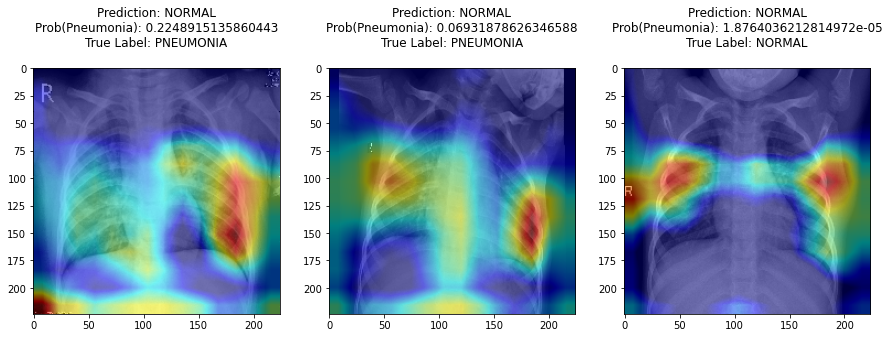

In [7]:
loaded_model = load_model('model_vgg.hdf5')
display_map_and_conf(loaded_model, test_generator)

### Predykcja

In [3]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import numpy as np

def predict_image(model, img_path):
    img = img_to_array(load_img(img_path, target_size=(224,224,3)))
    img = img * (1./255)
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    label = 'PNEUMONIA' if pred >= 0.5 else 'NORMAL'
    print("prediction: ", label, "P(Pneumonia): ", pred[0][0])

In [4]:
m = load_model('model_vgg.hdf5')
predict_image(m, '/home/przemek/Deep Learning/road-to-deep-learning/road-to-deep-learning/data/pneumonia-xrays/chest_xray/train/NORMAL/IM-0410-0001.jpeg')

prediction:  NORMAL P(Pneumonia):  6.303576e-05


### Zadanie

* Opisz na czym polega **transfer learning**. Jak został on wykorzystany w powyższym przykładzie?
* Dokonaj ewaluacji modelu VGG16. Użyj [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) oraz [ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html). Wyznacz wartości **Precision** oraz **Recall**.